In [ ]:

# Single-Cell Exploration

In [ ]:
## Set up logging ##
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info("Starting single-cell data wrangling...")

In [ ]:
## Load Kang et al. single-cell dataset ##

In [ ]:
## Load single-cell atalas data complet
import os

## Data directory
dataDir = "../../../../data/atlas_dataset"
sc_dict = {os.path.splitext(f)[0]: os.path.join(dataDir, f) for f in sc_files}

## Make sure files exist
samples = {k: v for k, v in sc_dict.items() if os.path.exists(v)}

In [ ]:
#datadir = "../../../../data/genexcell/"
#h5ad_files = [f for f in os.listdir(datadir) if f.endswith('.h5ad')]
#sc_dict = {os.path.splitext(f)[0]: os.path.join(datadir, f) for f in h5ad_files}

In [ ]:
## Get data from genexcell

# import cellxgene_census

# census = cellxgene_census.open_soma(census_version="latest")
# census["census_info"]["summary"].read().concat().to_pandas()

# datasets = census["census_info"]["datasets"].read().concat().to_pandas()
# datasets["citation"]

# # dataset_ids = {"scRNAseq": "02792605-4760-4023-82ad-40fc4458a5db", "snRNAseq": "1873a18a-66fd-4a4d-8277-a872c93f5b59"}
# dataset_ids = {"ICB": "09595871-5cde-4351-88f9-b3c37b3ed466"}



# # Check each dataset ID from the dictionary and collect matching rows
# matching_rows = []
# for name, dataset_id in dataset_ids.items():
#     is_present = dataset_id in datasets['dataset_id'].values
#     if is_present:
#         row_indices = datasets[datasets['dataset_id'] == dataset_id].index.tolist()
#         print(f"{name} ({dataset_id}): Present in rows {row_indices}")
#         matching_rows.extend(row_indices)
#     else:
#         print(f"{name} ({dataset_id}): Not found")

# # Create subset DataFrame with only the matching rows
# if matching_rows:
#     datasubset = datasets.loc[matching_rows]
#     print(f"\nCreated subset with {len(datasubset)} rows")
#     print(datasubset[['dataset_id']].head())  # Show the dataset_id column to verify
# else:
#     print("No matching rows found")


# ## Check publication
# datasubset["collection_doi_label"]

# ## Retrieve cells

# import cellxgene_census

# # Get the dataset IDs as a list
# dataset_id_list = list(dataset_ids.values())

# census = cellxgene_census.open_soma()
# keys = list(census["census_data"]["homo_sapiens"].obs.keys())

# # Query the census to get an AnnData object
# with cellxgene_census.open_soma() as census:
#     adata = cellxgene_census.get_anndata(
#         census=census,
#         organism="Homo sapiens",  # or "mus_musculus" depending on your data
#         measurement_name="RNA",
#         obs_value_filter=f"dataset_id in {dataset_id_list}",
#         var_value_filter=None,  # You can add gene filtering here if needed
#         obs_column_names=["soma_joinid", "dataset_id", "assay", "disease", 'cell_type', 'cell_type_ontology_term_id','tissue','tissue_ontology_term_id'],
#         var_column_names= ["soma_joinid", "feature_id", "feature_name"]
#     )

# print(f"AnnData object created with {adata.n_obs} cells and {adata.n_vars} genes")
# print(adata.obs['dataset_id'].value_counts())





# adata.obs['cell_type'].value_counts()

# ## Remove NAs
# import numpy as np
# import scipy.sparse
# import scanpy as sc

# # First clean NaN values from the main data
# if scipy.sparse.issparse(adata.X):
#     # For sparse matrices
#     adata.X.data = np.nan_to_num(adata.X.data, nan=0.0)
# else:
#     # For dense matrices
#     adata.X = np.nan_to_num(adata.X, nan=0.0)

# print("NaN values replaced with 0 in main matrix")


# # Minimal filtering
# sc.pp.filter_genes(adata, min_cells=1)

# # Set feature_name as the new var_names (index)
# adata.var_names = adata.var['feature_name']

# # Optional: Make the names unique if there are duplicates
# adata.var_names_make_unique()

# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# adata.raw = adata

In [ ]:
## Load all files and create integrated AnnData object
import scanpy as sc
import numpy as np
import scipy.sparse

adata_dict = {k: sc.read_h5ad(v) for k, v in sc_dict.items()}

for key, adata in adata_dict.items():
    print(f"{key}: {adata.shape}")

## Concatenate all single-cell datasets
oSC = sc.concat(adata_dict.values(), label="sample", join='outer')

## No count data are provided - we'll create a count layer. 
counts_sparse = oSC.X.copy()
counts_sparse.data = np.rint(np.power(10, counts_sparse.data.astype(float))).astype(int)

oSC.layers["counts"] = counts_sparse

## Add patientID column to metadata
unique_patients = {name: f'P{i+1}' for i, name in enumerate(oSC.obs['Patient'].unique())}
oSC.obs['patientID'] = oSC.obs['Patient'].map(unique_patients)

oSC.obs["Organ_origin"] = oSC.obs["Organ_origin"].str.replace(r"[ _-]", "", regex=True)

oSC.obs["sampleName"] = (
    oSC.obs["Organ_origin"].astype(str) + "_" +
    oSC.obs["Tissue"].astype(str) + "_" +
    oSC.obs["patientID"].astype(str)
)

oSC.obs["sampleName"] = (
    oSC.obs["sampleName"]
    .str.replace("AdrenalGland", "AdrenalGl")
    .str.replace("SmallIntestine", "SIntestin")
    .str.replace("Neuroendocrine", "Neuroend")
    .str.replace("FallopianTube", "FallopTube")
)

oSC.obs["sampleName"] = (
    oSC.obs["sampleName"]
    .str.replace("SIntestin", "SIntestine")
)

## Checking ##
matches = oSC.obs[oSC.obs["sampleName"].str.contains(r"_P1(?!\d)", regex=True)]["sampleName"]
print(matches)

## filtering for patients with tumor and normal samples
tn_patients = (
    oSC.obs.groupby("patientID")["Tissue"]
    .transform(lambda x: set(["Tumor", "Normal"]).issubset(set(x)))
)
oSC = oSC[tn_patients].copy()

## Check organ representation ##
df = oSC.obs[['sampleName', 'Tissue', 'Organ_origin']]
df = df.drop_duplicates().sort_values(by=['Organ_origin', 'Tissue', 'sampleName'])
df.value_counts('Organ_origin')

## Remove all samples with less than 10 samples:
counts = df['Organ_origin'].value_counts()
df_filtered = df[df['Organ_origin'].isin(counts[counts >= 10].index)]


## Filtering the anndata object ##
oSC = oSC[oSC.obs['sampleName'].isin(df_filtered['sampleName'])].copy()

## save object
oSC.write_h5ad("../../../../data/kang_tn_filtered.h5ad")

#########################################
## Create count and Intensity dataset  ##
#########################################

## counts ##
import numpy as np
import pandas as pd
from scipy import sparse

# Get the counts matrix (cells x genes) and sample labels
counts = oSC.layers["counts"]
sample_names = oSC.obs['sampleName'].values

# Get unique sample names and their indices
unique_samples, inverse = np.unique(sample_names, return_inverse=True)

# Prepare an empty sparse matrix for pseudobulk (samples x genes)
pseudobulk = sparse.lil_matrix((len(unique_samples), counts.shape[1]), dtype=counts.dtype)

# For each sample, compute the mean across cells
for i, sample in enumerate(unique_samples):
    idx = np.where(inverse == i)[0]
    # mean along axis 0 (cells)
    pseudobulk[i, :] = counts[idx].mean(axis=0)

# Convert to DataFrame (optional)
pseudobulk_df = pd.DataFrame(
    pseudobulk.toarray(),
    index=unique_samples,
    columns=oSC.var_names
)

pseudobulk_df = pseudobulk_df.T

# Remove zero only rows
pseudobulk_df = pseudobulk_df[(pseudobulk_df != 0).any(axis=1)]

pseudobulk_df['gene_id'] = pseudobulk_df.index

# Move gene_id to the first column (optional)
cols = ['gene_id'] + [col for col in pseudobulk_df.columns if col != 'gene_id']
pseudobulk_df = pseudobulk_df[cols]

# Save as tab-delimited file
pseudobulk_df.to_csv('pseudobulk.tsv', sep='\t', index=False)
pseudobulk_df = pseudobulk_df[cols]

pseudobulk_df.to_csv('../../../../data/kang.tn.filtered.pseudobulk.counts.txt', sep='\t', index=False)

gene_ids = pseudobulk_df['gene_id'].tolist()

## get gene_ids to subset expression pseudobulk

## expression intensity ##
import numpy as np
import pandas as pd
from scipy import sparse

# Get the counts matrix (cells x genes) and sample labels
counts = oSC.X
sample_names = oSC.obs['sampleName'].values

# Get unique sample names and their indices
unique_samples, inverse = np.unique(sample_names, return_inverse=True)

# Prepare an empty sparse matrix for pseudobulk (samples x genes)
pseudobulk = sparse.lil_matrix((len(unique_samples), counts.shape[1]), dtype=counts.dtype)

# For each sample, compute the mean across cells
for i, sample in enumerate(unique_samples):
    idx = np.where(inverse == i)[0]
    # mean along axis 0 (cells)
    pseudobulk[i, :] = counts[idx].mean(axis=0)

# Convert to DataFrame (optional)
pseudobulk_df = pd.DataFrame(
    pseudobulk.toarray(),
    index=unique_samples,
    columns=oSC.var_names
)

pseudobulk_df = pseudobulk_df.T
pseudobulk_df = pseudobulk_df.round(3)

# keep only rows that are also present in the countset
pseudobulk_df = pseudobulk_df[pseudobulk_df.index.isin(gene_ids)]

pseudobulk_df['gene_id'] = pseudobulk_df.index

# Move gene_id to the first column (optional)
cols = ['gene_id'] + [col for col in pseudobulk_df.columns if col != 'gene_id']
pseudobulk_df = pseudobulk_df[cols]

pseudobulk_df.to_csv('../../../../data/kang.tn.filtered.pseudobulk.expression.txt', sep='\t', index=False)

##

import pandas as pd

# Assume oSC is your AnnData object and oSC.obs['sampleName'] contains the labels

# 1. Convert the count matrix to a DataFrame (genes as rows, cells as columns)
counts_df = pd.DataFrame(
    oSC.X.toarray() if hasattr(oSC.X, "toarray") else oSC.X,
    index=oSC.obs_names,
    columns=oSC.var_names
)

# 2. Add sampleName as a column
counts_df['sampleName'] = oSC.obs['sampleName'].values

# 3. Group by sampleName and average (mean) across all cells with the same label
pseudobulk = counts_df.groupby('sampleName').mean()

# 4. (Optional) If you want genes as rows and sampleNames as columns, transpose:
# pseudobulk = pseudobulk.T

# pseudobulk now contains the average expression for each gene per sampleName


##################################
## Downsampling using geosketch ##
##################################
## To keep things simple, we will downsize using geo sketch
from geosketch import gs

sc.pp.pca(oSC, n_comps=50, key_added="X_pca")
N = 500000 # Number of samples to obtain from the data set.
X_dimred = oSC.obsm['X_pca']
sketch_index = gs(X_dimred, N, replace=False)




oSC.shape






In [ ]:
# Review single-cell data

In [1]:
import os
os.getcwd()

'/nemo/stp/babs/working/boeings/Projects/boeings/stefan.boeing/625_liver_cancer_target_report/scripts/targetreport/analyses/main_report_ipynb'

In [3]:
import scanpy as sc

fno = "../../../../data/kang_tn_filtered.h5ad"
oSC = sc.read_h5ad(fno)
oSC.obs['clusterName'] = oSC.obs['Celltype']
oSC

AnnData object with n_obs × n_vars = 890528 × 36601
    obs: 'Dataset', 'Organ_origin', 'Sample', 'Patient', 'Tissue', 'Cancer type', 'cnv_status', 'Celltype', 'sample', 'patientID', 'sampleName', 'clusterName'
    layers: 'counts'

In [5]:
sc.settings.set_figure_params(
    dpi=80,
    facecolor="White",
    frameon=False
)

sc.pp.highly_variable_genes(oSC, flavour="seurat_v3")


In [7]:
sc.pp.pca(oSC, n_comps=50, key_added="X_pca")
sc.pp.neighbors(oSC)
sc.tl.umap(oSC)

## Sketch dataset
X_dimred = oSC.obsm['X_pca']
sketch_index = gs(X_dimred, N, replace=False)


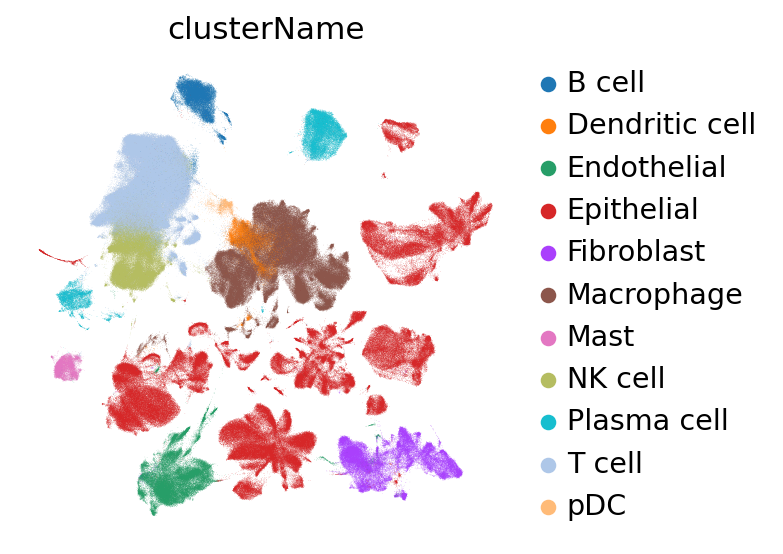

In [8]:
sc.pl.umap(oSC, color = "clusterName")

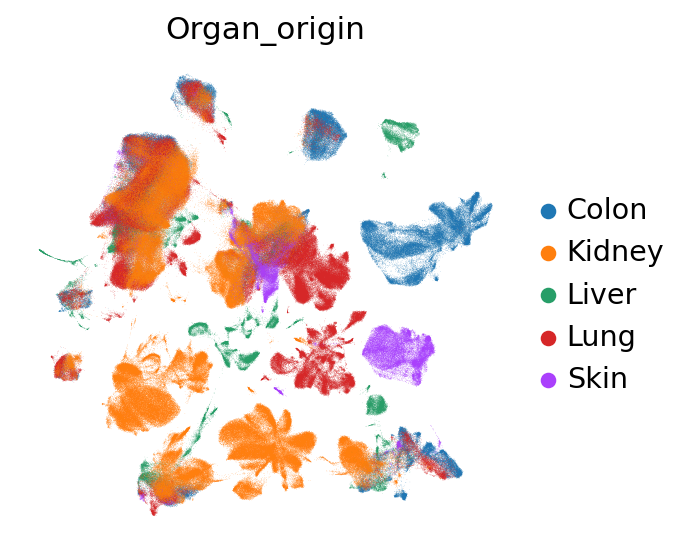

In [13]:
sc.pl.umap(oSC, color = "Organ_origin")